In [1]:
import glob
import matplotlib
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
activities = {'Brush_teeth': 0, 
             'Climb_stairs': 1, 
             'Comb_hair': 2, 
             'Descend_stairs': 3, 
             'Drink_glass': 4, 
             'Eat_meat': 5, 
             'Eat_soup': 6, 
             'Getup_bed': 7, 
             'Liedown_bed': 8, 
             'Pour_water': 9, 
             'Sitdown_chair': 10, 
             'Standup_chair': 11, 
             'Use_telephone': 12, 
             'Walk': 13}

In [2]:
labels = sorted(activities.keys(), key = lambda x: x[0])
labels

['Brush_teeth',
 'Climb_stairs',
 'Comb_hair',
 'Drink_glass',
 'Descend_stairs',
 'Eat_meat',
 'Eat_soup',
 'Getup_bed',
 'Liedown_bed',
 'Pour_water',
 'Standup_chair',
 'Sitdown_chair',
 'Use_telephone',
 'Walk']

In [3]:
files = [None] * len(activities)
train_files = [None] * len(activities)
test_files = [None] * len(activities)
path = '/Users/xinqu/Sandbox/CS498 Applied Machine Learning/HW/HW5/HMP_Dataset/'
def read_data(activities):
    for act in activities:
        f = glob.glob(path + act + '/*.txt')
        files[activities[act]] = f
read_data(activities)

In [4]:
files_length = []
for i in range(14):
    files_length.append(len(files[i]))
files_length

[12, 102, 31, 42, 100, 5, 3, 101, 28, 100, 100, 102, 13, 100]

In [ ]:
def train_test_files(files):
    for i, file_ in enumerate(files):
        train_files[i], test_files[i], y_train, y_test = train_test_split(files[i], 
                                                                              [i]*len(files[i]), test_size=0.33)

In [5]:
def get_chunk_vector(filelist, chunk_size):
    ##read all files in each folder and get segments of vector
    segment = []
    for filename in filelist:
        data = np.genfromtxt(filename, dtype = int)
        for idx, d in enumerate(data):
            if idx != 0 and idx % chunk_size == 0:
                tmp = np.array([])
                tmp = np.append(tmp, [data[idx - chunk_size: idx]]) 
                segment.append(tmp)
    segment = np.array(segment)
    return segment

In [6]:
segment_list_act = []##segments list by each folder
for i in range(len(files)):
    segment_list_act.append(get_chunk_vector(files[i], 16))

In [7]:
import warnings
warnings.filterwarnings('ignore')
codebooks = []
##create idc with whole data each folder
def get_codebook(segment_list_act, cluster_size):##run kmeans on each segment vector for each folder
    for i in range(len(files)):
        center, label = kmeans2(segment_list_act[i], cluster_size)
        codebooks.append(center)
get_codebook(segment_list_act, 15)

In [8]:
data_files = []
for act in activities:
    data_files.append([act])
data_files

[['Standup_chair'],
 ['Climb_stairs'],
 ['Brush_teeth'],
 ['Drink_glass'],
 ['Walk'],
 ['Descend_stairs'],
 ['Comb_hair'],
 ['Eat_meat'],
 ['Use_telephone'],
 ['Liedown_bed'],
 ['Sitdown_chair'],
 ['Eat_soup'],
 ['Getup_bed'],
 ['Pour_water']]

In [9]:
histograms = np.array([])
histograms_labels = []
def get_histogram(files, codebooks, cluster_size, chunk_size):
    ###get histograms for each file in each folder
    global histograms, histograms_labels
    for i, j in enumerate(data_files):
        for act in j:
            for filename in files[i]:
                segment = [] ##get segment for each file
                data = np.genfromtxt(filename, dtype = int)
                for idx, d in enumerate(data):
                    if idx != 0 and idx % chunk_size == 0:
                        tmp = np.array([])
                        tmp = np.append(tmp, [data[idx - chunk_size: idx]])
                        segment.append(tmp)
                traincode, distortion = vq(segment, codebooks[i])
                hist = np.bincount(traincode, minlength = cluster_size)
                if len(histograms) == 0:
                    histograms = np.array([hist])
                else:
                    histograms = np.concatenate((histograms, np.array([hist])), axis = 0)
                histograms_labels.append(i)
get_histogram(files, codebooks, 15, 16)

In [10]:
from sklearn.metrics import confusion_matrix
accuracy = []
cm = []
for i in range(3):
    classifier = RandomForestClassifier(max_depth = 20, random_state = 0)
    X_train, X_test, y_train, y_test = train_test_split(histograms, histograms_labels, 
                                                        test_size=0.33, stratify=histograms_labels)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy.append(accuracy_score(predictions, y_test))
    cm.append(confusion_matrix(y_test, predictions))
accuracy

[0.7653429602888087, 0.7870036101083032, 0.7472924187725631]

In [11]:
np.mean(accuracy)

0.766546329723225

In [12]:
##avg error rate
1 - np.mean(accuracy)

0.233453670276775

In [13]:
print(cm[1])

[[ 2  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0 27  0  2  1  0  0  0  0  1  2  1  0  0]
 [ 0  0  6  0  1  0  0  0  1  2  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  2  2  3  0  0  1]
 [ 0  0  0  0 28  0  0  0  0  2  3  0  0  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 29  0  1  0  3  0  0]
 [ 0  2  1  2  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  3  1 23  1  4  0  0]
 [ 0  0  0  0  2  0  0  0  0  1 29  1  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  2 30  0  0]
 [ 0  0  0  1  2  0  0  0  0  0  0  0  1  0]
 [ 0  2  0  0  1  0  0  0  0  0  0  0  0 30]]


Text(0,0.5,'True')

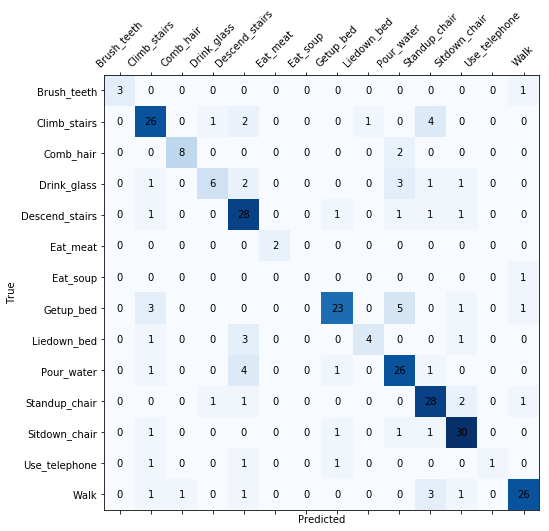

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.matshow(cm[0], cmap=plt.cm.Blues)
for i in xrange(14):
    for j in xrange(14):
        c = cm[0][j,i]
        ax.text(i, j, str(c), va='center', ha='center')
ax.set_xticks(np.arange(0, 14))
ax.set_xticklabels(labels, minor = False, rotation = 45)
ax.set_yticks(np.arange(0, 14))
ax.set_yticklabels(labels, minor = False)
plt.xlabel('Predicted')
plt.ylabel('True')

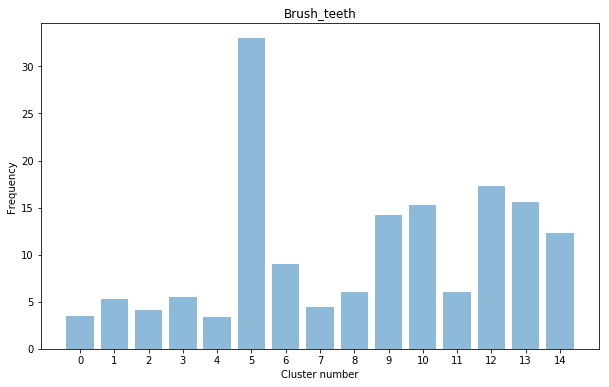

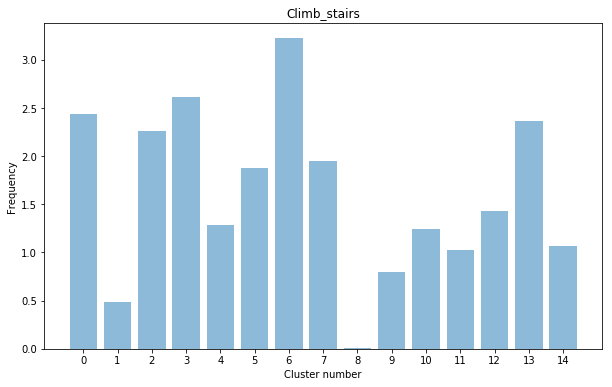

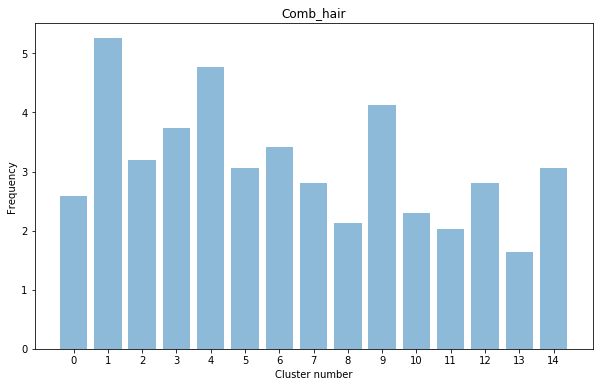

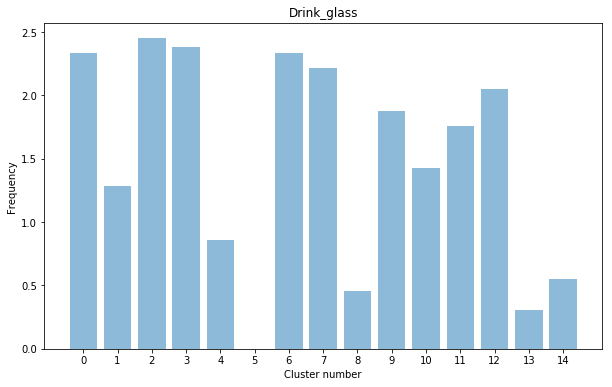

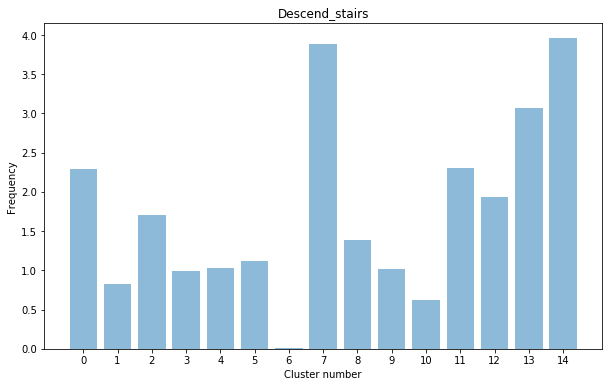

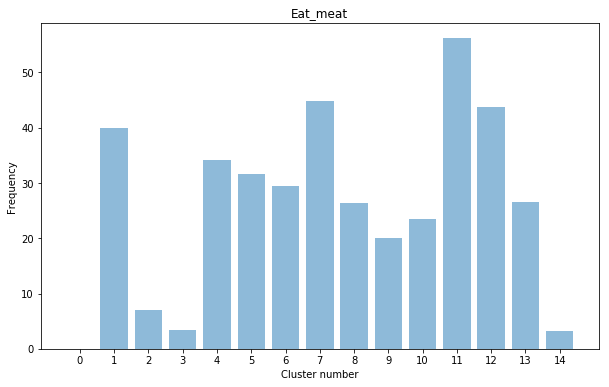

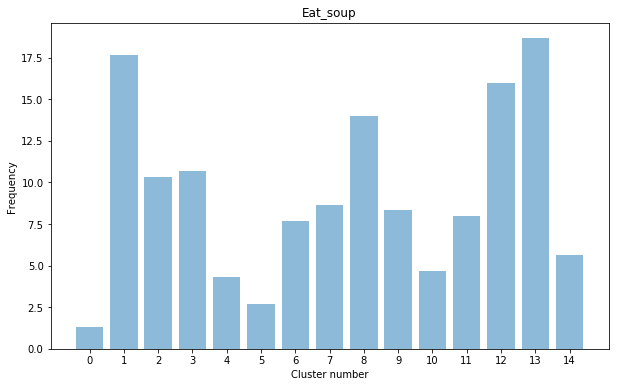

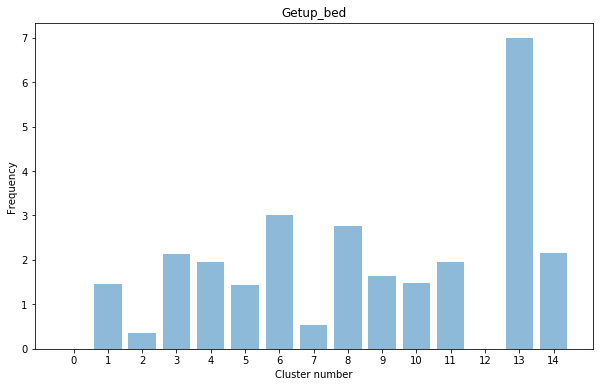

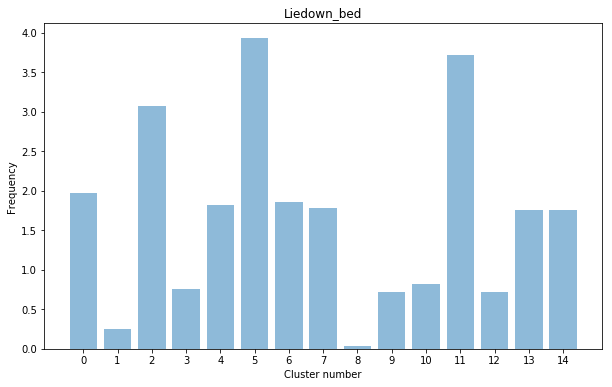

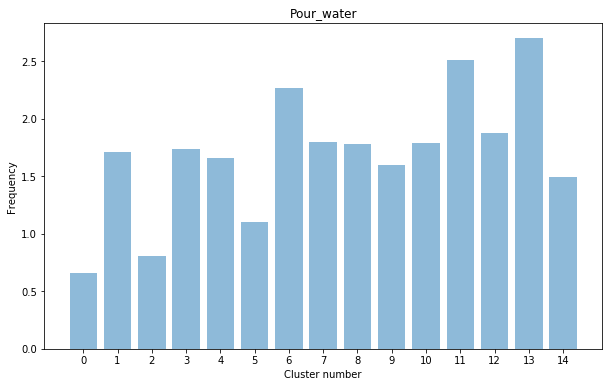

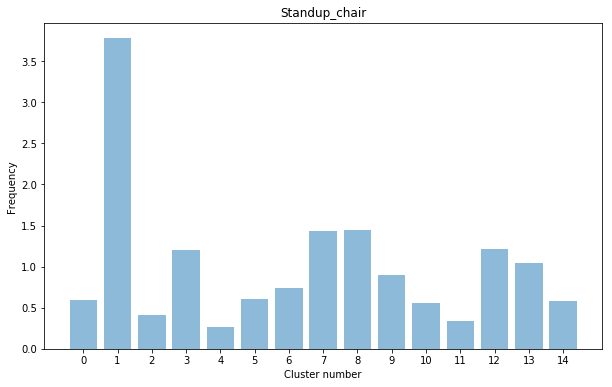

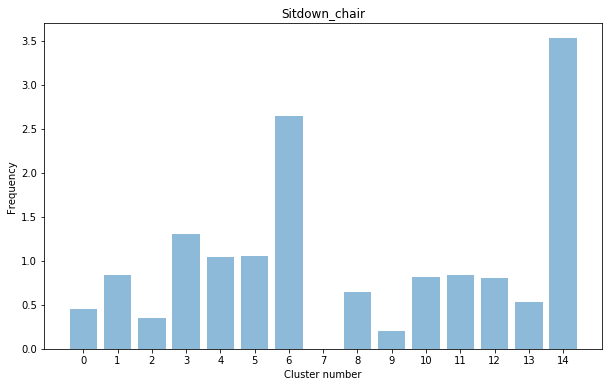

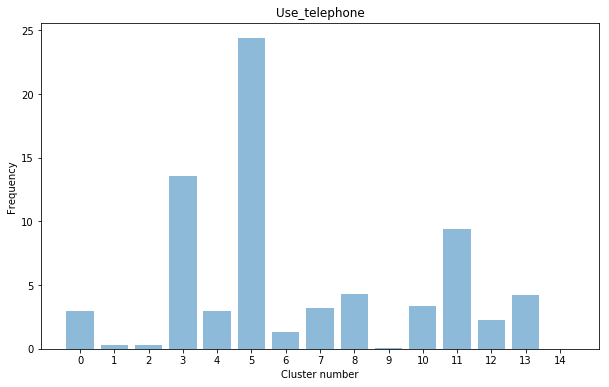

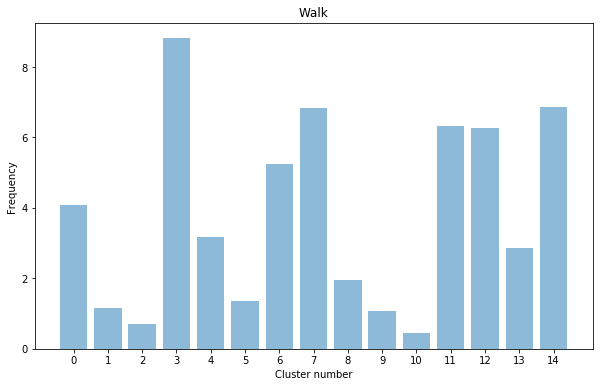

In [15]:
mean_hist = []
i = 0
j = 0
while j < 14 and i <= sum(files_length):
    hist_tmp = histograms[i : i + files_length[j]]
    i += files_length[j]
    y = np.arange(15)
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 6))
    plt.bar(y, np.mean(hist_tmp, axis = 0), align = 'center', alpha = 0.5)
    plt.xticks(y, y)
    plt.ylabel('Frequency')
    plt.xlabel('Cluster number')
    plt.title(labels[j])
    plt.show()
    j += 1